## Galáxias não barradas e interações 2

Este notebook possui cálculos para melhor caracterizar uma galáxia não barrada interagindo com um satélite (galáxia anã) a partir de t = 8 Gyr. Os cálculos aqui apresentados são de: força da barra, desvio padrão de velocidades verticais, evolução da fração de gás e de formação estelar, órbita do satélite e mapas de altura e velocidade. Algumas funções importadas estão escritas em bar_funcs.py

Andressa Wille, 11/08/2023

Aqui estamos usando:

    - Galáxia com 75% de gás relaxado com SF e 20% de bojo
    
    +
    
    - Galáxias anãs satélites
    
com massas $ M = 1 \times 10^{10}\mathrm{{M}_\odot}, M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, M = 0.1 \times 10^{10}\mathrm{{M}_\odot}$ e raios orbitais de $r = 10 \, \mathrm{kpc}, r = 20 \, \mathrm{kpc}, r = 30 \, \mathrm{kpc}$.

In [1]:
import matplotlib.pyplot as plt
import h5py
from numpy import *
import numpy as np
from scipy import stats
import math
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import savgol_filter
from bar_funcs import *

Unable to import [unsiotools.py_unstools]....


In [2]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 15

In [3]:
#caminhos galáxia + satélite
path_01_10 = 'satelites/nb-sat01-10/'
path_01_20 = 'satelites/nb-sat01-20/'
path_01_30 = 'satelites/nb-sat01-30/'
path_05_10 = 'satelites/nb-sat05-10/'
path_05_20 = 'satelites/nb-sat05-20/'
path_05_30 = 'satelites/nb-sat05-30/'
path_1_10 = 'satelites/nb-sat1-10/'
path_1_20 = 'satelites/nb-sat1-20/'
path_1_30 = 'satelites/nb-sat1-30/'

paths = [path_01_10, path_01_20, path_01_30, path_05_10, path_05_20, path_05_30, path_1_10, path_1_20, path_1_30]

In [4]:
n_snapshots = 120

### Força da barra

In [6]:
#arrays tempo
time_01_10 = np.empty(n_snapshots)
time_01_20 = np.empty(n_snapshots)
time_01_30 = np.empty(n_snapshots)

time_05_10 = np.empty(n_snapshots)
time_05_20 = np.empty(n_snapshots)
time_05_30 = np.empty(n_snapshots)

time_1_10 = np.empty(n_snapshots)
time_1_20 = np.empty(n_snapshots)
time_1_30 = np.empty(n_snapshots)

In [7]:
#arrays para força da barra
A2_01_10 = np.empty(n_snapshots)
A2_01_20 = np.empty(n_snapshots)
A2_01_30 = np.empty(n_snapshots)

A2_05_10 = np.empty(n_snapshots)
A2_05_20 = np.empty(n_snapshots)
A2_05_30 = np.empty(n_snapshots)

A2_1_10 = np.empty(n_snapshots)
A2_1_20 = np.empty(n_snapshots)
A2_1_30 = np.empty(n_snapshots)

In [8]:
#tempo
for p, path in enumerate(paths):

    for j in range (0, n_snapshots): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time_01_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 1:
            time_01_20[j] = round(f['Header'].attrs['Time'], 2)    
        
        if p == 2:
            time_01_30[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 3:
            time_05_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 4:
            time_05_20[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 5:
            time_05_30[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 6:
            time_1_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 7:
            time_1_20[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 8:
            time_1_30[j] = round(f['Header'].attrs['Time'], 2)

In [9]:
#força da barra
for p, path in enumerate(paths):

    for j in range (0, n_snapshots): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        #ler info disco e stars e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        
                    
        if j == 0:
            m_star = 0
            x_new_star = 0
            y_new_star = 0
            
        else:
        
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            m_star = np.array(f_star['Masses'])

            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)

            
        #juntar disk + stars
        if j == 0:
            m = m_disk
            x = x_new_disk
            y = y_new_disk
        
        else:
            m = np.concatenate((m_star,m_disk))
            x = np.concatenate((x_new_star,x_new_disk))
            y = np.concatenate((y_new_star,y_new_disk))

        #calcular força da barra
        if p == 0:
            A2_01_10[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
            
        if p == 1:
            A2_01_20[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
            
        if p == 2:
            A2_01_30[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
            
        if p == 3:
            A2_05_10[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
            
        if p == 4:
            A2_05_20[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
            
        if p == 5:
            A2_05_30[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
            
        if p == 6:
            A2_1_10[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
            
        if p == 7:
            A2_1_20[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)
        
        if p == 8:
            A2_1_30[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)

In [5]:
#caminho galáxia isolada
path = 'n_barrada/'
paths1 = [path]

In [6]:
n_snapshots_ = 281

In [11]:
time = np.empty(n_snapshots_)

In [12]:
A2 = np.empty(n_snapshots_)

In [14]:
#tempo
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time[j] = round(f['Header'].attrs['Time'], 2)

In [15]:
#força da barra
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        #ler info disco e stars e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        
        if j == 0:
            m_star = 0
            x_new_star = 0
            y_new_star = 0
            
        else:
        
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            m_star = np.array(f_star['Masses'])

            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
 
        #juntar disk + stars
        if j == 0:
            m = m_disk
            x = x_new_disk
            y = y_new_disk
        
        else:
            m = np.concatenate((m_star,m_disk))
            x = np.concatenate((x_new_star,x_new_disk))
            y = np.concatenate((y_new_star,y_new_disk))

        #calcular força da barra
        if p == 0:
            A2[j] = bar_strength(m=m, x=x, y=y, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)           

In [15]:
time_01_10 = 8.0 + time_01_10
time_01_20 = 8.0 + time_01_20
time_01_30 = 8.0 + time_01_30
time_05_10 = 8.0 + time_05_10
time_05_20 = 8.0 + time_05_20
time_05_30 = 8.0 + time_05_30
time_1_10 = 8.0 + time_1_10
time_1_20 = 8.0 + time_1_20
time_1_30 = 8.0 + time_1_30

In [17]:
print(f'A2 final isolada: {round(A2[280],2)}')

print(f'A2 final sat 01 10: {round(A2_01_10[119],2)}')
print(f'A2 final sat 01 20: {round(A2_01_20[119],2)}')
print(f'A2 final sat 01 30: {round(A2_01_30[119],2)}')

print(f'A2 final sat 05 10: {round(A2_05_10[119],2)}')
print(f'A2 final sat 05 20: {round(A2_05_20[119],2)}')
print(f'A2 final sat 05 30: {round(A2_05_30[119],2)}')

print(f'A2 final sat 1 10: {round(A2_1_10[119],2)}')
print(f'A2 final sat 1 20: {round(A2_1_20[119],2)}')
print(f'A2 final sat 1 30: {round(A2_1_30[119],2)}')

A2 final isolada: 0.19
A2 final sat 01 10: 0.23
A2 final sat 01 20: 0.22
A2 final sat 01 30: 0.21
A2 final sat 05 10: 0.2
A2 final sat 05 20: 0.18
A2 final sat 05 30: 0.19
A2 final sat 1 10: 0.15
A2 final sat 1 20: 0.07
A2 final sat 1 30: 0.09


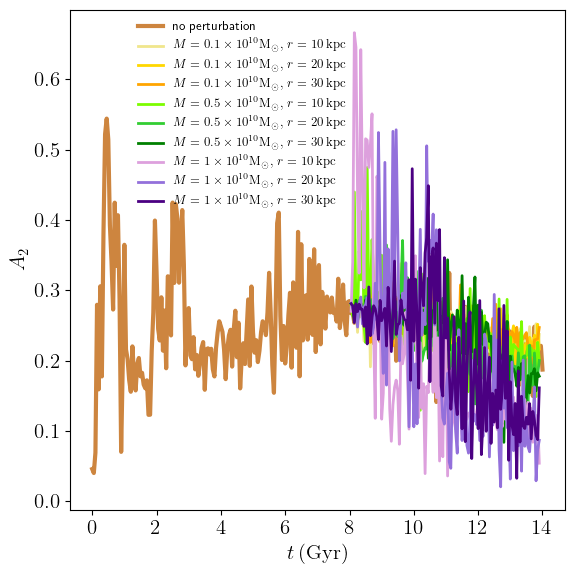

In [36]:
plt.figure(figsize=[6,6])
plt.plot(time, A2, color='peru', lw=3, label='no perturbation')

plt.plot(time_01_10[1:119], A2_01_10[1:119], color='khaki', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20[1:119], A2_01_20[1:119], color='gold', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30[1:119], A2_01_30[1:119], color='orange', ls = '-',  lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10[1:119], A2_05_10[1:119], color='lawngreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20[1:119], A2_05_20[1:119], color='limegreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30[1:119], A2_05_30[1:119], color='green', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10[1:119], A2_1_10[1:119], color='plum', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20[1:119], A2_1_20[1:119], color='mediumpurple', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30[1:119], A2_1_30[1:119], color='indigo', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$A_2$', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
#plt.legend(frameon=False, fontsize=14)
plt.legend(frameon=False, fontsize=9, loc="center right", bbox_to_anchor=(0.58,0.79))
plt.tight_layout()
#plt.savefig('a2_gnb.png')

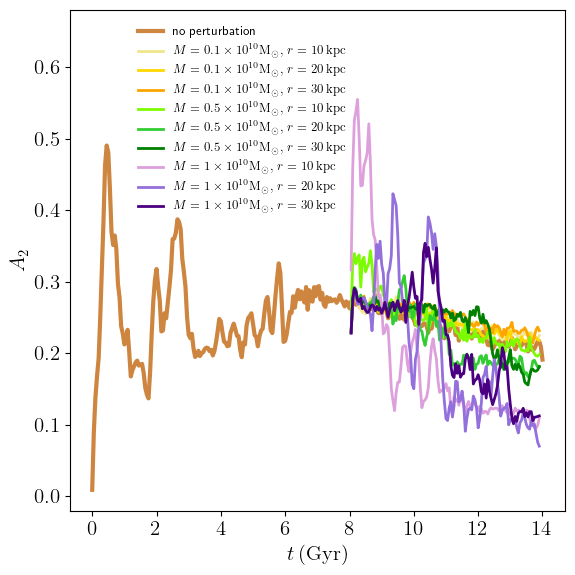

In [20]:
#curva suavizada
A2_smooth = savgol_filter(A2, window_length=9, polyorder=3)

A2_01_10_smooth = savgol_filter(A2_01_10, window_length=9, polyorder=3)
A2_01_20_smooth = savgol_filter(A2_01_20, window_length=9, polyorder=3)
A2_01_30_smooth = savgol_filter(A2_01_30, window_length=9, polyorder=3)

A2_05_10_smooth = savgol_filter(A2_05_10, window_length=9, polyorder=3)
A2_05_20_smooth = savgol_filter(A2_05_20, window_length=9, polyorder=3)
A2_05_30_smooth = savgol_filter(A2_05_30, window_length=9, polyorder=3)

A2_1_10_smooth = savgol_filter(A2_1_10, window_length=9, polyorder=3)
A2_1_20_smooth = savgol_filter(A2_1_20, window_length=9, polyorder=3)
A2_1_30_smooth = savgol_filter(A2_1_30, window_length=9, polyorder=3)


plt.figure(figsize=[6,6])#, dpi=300)
plt.plot(time, A2_smooth, color='peru', lw=3, label='no perturbation')

plt.plot(time_01_10[1:119], A2_01_10_smooth[1:119], color='khaki', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20[1:119], A2_01_20_smooth[1:119], color='gold', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30[1:119], A2_01_30_smooth[1:119], color='orange', ls = '-',  lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10[1:119], A2_05_10_smooth[1:119], color='lawngreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20[1:119], A2_05_20_smooth[1:119], color='limegreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30[1:119], A2_05_30_smooth[1:119], color='green', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10[1:119], A2_1_10_smooth[1:119], color='plum', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20[1:119], A2_1_20_smooth[1:119], color='mediumpurple', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30[1:119], A2_1_30_smooth[1:119], color='indigo', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$A_2$', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.ylim(-0.02, 0.68)
plt.legend(frameon=False, fontsize=9, loc="center right", bbox_to_anchor=(0.58,0.78))
plt.tight_layout()
#plt.savefig('a2_gnb_smooth.png')

### Desvio padrão de velocidades verticais

In [16]:
sigma_vz = np.empty(n_snapshots_)
sigma_vr = np.empty(n_snapshots_)
sigma_v = np.empty(n_snapshots_)

In [17]:
#arrays de desvio de vz
sigma_vz_01_10 = np.empty(n_snapshots)
sigma_vz_01_20 = np.empty(n_snapshots)
sigma_vz_01_30 = np.empty(n_snapshots)

sigma_vz_05_10 = np.empty(n_snapshots)
sigma_vz_05_20 = np.empty(n_snapshots)
sigma_vz_05_30 = np.empty(n_snapshots)

sigma_vz_1_10 = np.empty(n_snapshots)
sigma_vz_1_20 = np.empty(n_snapshots)
sigma_vz_1_30 = np.empty(n_snapshots)

In [18]:
#arrays de desvio de vr
sigma_vr_01_10 = np.empty(n_snapshots)
sigma_vr_01_20 = np.empty(n_snapshots)
sigma_vr_01_30 = np.empty(n_snapshots)

sigma_vr_05_10 = np.empty(n_snapshots)
sigma_vr_05_20 = np.empty(n_snapshots)
sigma_vr_05_30 = np.empty(n_snapshots)

sigma_vr_1_10 = np.empty(n_snapshots)
sigma_vr_1_20 = np.empty(n_snapshots)
sigma_vr_1_30 = np.empty(n_snapshots)

In [19]:
sigma_v_01_10 = np.empty(n_snapshots)
sigma_v_01_20 = np.empty(n_snapshots)
sigma_v_01_30 = np.empty(n_snapshots)

sigma_v_05_10 = np.empty(n_snapshots)
sigma_v_05_20 = np.empty(n_snapshots)
sigma_v_05_30 = np.empty(n_snapshots)

sigma_v_1_10 = np.empty(n_snapshots)
sigma_v_1_20 = np.empty(n_snapshots)
sigma_v_1_30 = np.empty(n_snapshots)

In [21]:
for p, path in enumerate(paths):

    for j in range (0, n_snapshots): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        #ler info disco e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        m_disk = np.array(f_disk['Masses'])
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

        
        if j == 0:
            m_star = 0
            x_new_star = 0
            y_new_star = 0
            z_new_star = 0 
            vx_star = 0
            vy_star = 0
            vz_star = 0
            
        else:
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            vx_star = np.array(f_star['Velocities'][:,0])
            vy_star = np.array(f_star['Velocities'][:,1])
            vz_star = np.array(f_star['Velocities'][:,2])
            m_star = np.array(f_star['Masses'])

            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
            vx_new_star, vy_new_star, vz_new_star = shift_com(m_star, vx_star, vy_star, vz_star)
 
        #juntar disk + stars
        if j == 0:
            x = x_new_disk
            y = y_new_disk
            z = z_new_disk
            vx = vx_new_disk
            vy = vy_new_disk
            vz = vz_new_disk
        
        else:
            z = np.concatenate((z_new_star,z_new_disk))
            x = np.concatenate((x_new_star,x_new_disk))
            y = np.concatenate((y_new_star,y_new_disk))
            vz = np.concatenate((vz_new_star,vz_new_disk))
            vx = np.concatenate((vx_new_star,vx_new_disk))
            vy = np.concatenate((vy_new_star,vy_new_disk))
            
        #velocidade radial
        vR = (x*vx + y*vy)/np.sqrt(x**2 + y**2)
        
        #calcular sigma vz
        if p == 0:
            sigma_vz_01_10[j] = np.std(vz)
            sigma_vr_01_10[j] = np.std(vR)
            sigma_v_01_10[j] = (np.std(vz))/(np.std(vR))
        if p == 1:
            sigma_vz_01_20[j] = np.std(vz)
            sigma_vr_01_20[j] = np.std(vR)
            sigma_v_01_20[j] = (np.std(vz))/(np.std(vR))
        if p == 2:
            sigma_vz_01_30[j] = np.std(vz)
            sigma_vr_01_30[j] = np.std(vR)
            sigma_v_01_30[j] = (np.std(vz))/(np.std(vR))
        if p == 3:
            sigma_vz_05_10[j] = np.std(vz)
            sigma_vr_05_10[j] = np.std(vR)
            sigma_v_05_10[j] = (np.std(vz))/(np.std(vR))
        if p == 4:
            sigma_vz_05_20[j] = np.std(vz)
            sigma_vr_05_20[j] = np.std(vR)
            sigma_v_05_20[j] = (np.std(vz))/(np.std(vR))
        if p == 5:
            sigma_vz_05_30[j] = np.std(vz)
            sigma_vr_05_30[j] = np.std(vR)
            sigma_v_05_30[j] = (np.std(vz))/(np.std(vR))
        if p == 6:
            sigma_vz_1_10[j] = np.std(vz)
            sigma_vr_1_10[j] = np.std(vR)
            sigma_v_1_10[j] = (np.std(vz))/(np.std(vR))
        if p == 7:
            sigma_vz_1_20[j] = np.std(vz)
            sigma_vr_1_20[j] = np.std(vR)
            sigma_v_1_20[j] = (np.std(vz))/(np.std(vR))
        if p == 8:
            sigma_vz_1_30[j] = np.std(vz)
            sigma_vr_1_30[j] = np.std(vR)
            sigma_v_1_30[j] = (np.std(vz))/(np.std(vR))

In [22]:
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        #ler info disco e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        m_disk = np.array(f_disk['Masses'])
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)


        if j == 0:
            m_star = 0
            x_new_star = 0
            y_new_star = 0
            z_new_star = 0 
            vx_star = 0
            vy_star = 0
            vz_star = 0
            
        else:
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            vx_star = np.array(f_star['Velocities'][:,0])
            vy_star = np.array(f_star['Velocities'][:,1])
            vz_star = np.array(f_star['Velocities'][:,2])
            m_star = np.array(f_star['Masses'])

            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
            vx_new_star, vy_new_star, vz_new_star = shift_com(m_star, vx_star, vy_star, vz_star)
 
        #juntar disk + stars
        if j == 0:
            x = x_new_disk
            y = y_new_disk
            z = z_new_disk
            vx = vx_new_disk
            vy = vy_new_disk
            vz = vz_new_disk
        
        else:
            z = np.concatenate((z_new_star,z_new_disk))
            x = np.concatenate((x_new_star,x_new_disk))
            y = np.concatenate((y_new_star,y_new_disk))
            vz = np.concatenate((vz_new_star,vz_new_disk))
            vx = np.concatenate((vx_new_star,vx_new_disk))
            vy = np.concatenate((vy_new_star,vy_new_disk))
            
        #velocidade radial
        vR = (x*vx + y*vy)/np.sqrt(x**2 + y**2)

        #calcular sigmas
        if p == 0:
            sigma_vz[j] = np.std(vz)
            sigma_vr[j] = np.std(vR)
            sigma_v[j] = (np.std(vz))/(np.std(vR))

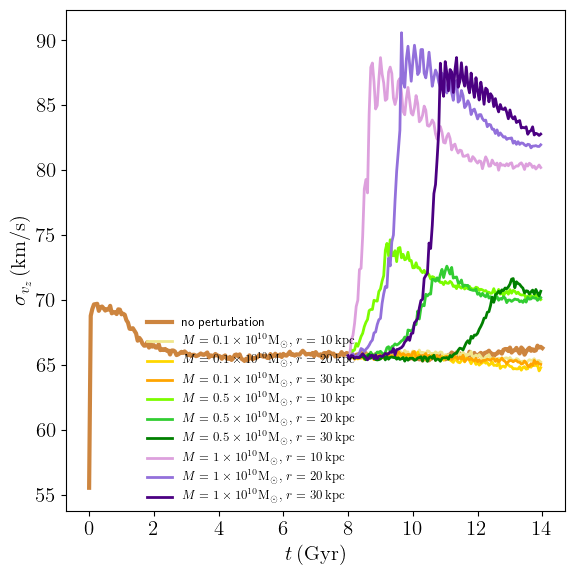

In [23]:
plt.figure(figsize=[6,6])#, dpi=300)
plt.plot(time, sigma_vz, color='peru', lw=3, label='no perturbation')

plt.plot(time_01_10, sigma_vz_01_10, color='khaki', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20, sigma_vz_01_20, color='gold', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30, sigma_vz_01_30, color='orange', ls = '-',  lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10, sigma_vz_05_10, color='lawngreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20, sigma_vz_05_20, color='limegreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30, sigma_vz_05_30, color='green', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10, sigma_vz_1_10, color='plum', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20, sigma_vz_1_20, color='mediumpurple', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30, sigma_vz_1_30, color='indigo', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\sigma_{v_z} \, \mathrm{(km/s)}$', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.legend(frameon=False, fontsize=9, loc="center right", bbox_to_anchor=(0.6,0.2))
plt.tight_layout()
#plt.savefig('sigma_vz_gnb-2.png')

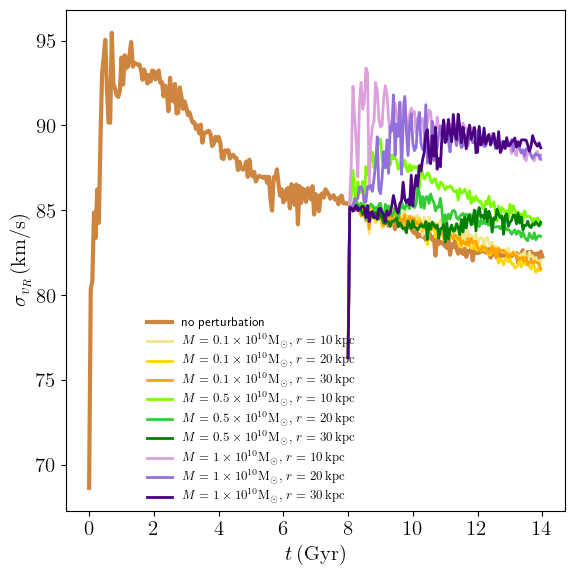

In [24]:
plt.figure(figsize=[6,6])#, dpi=300)
plt.plot(time, sigma_vr, color='peru', lw=3, label='no perturbation')

plt.plot(time_01_10, sigma_vr_01_10, color='khaki', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20, sigma_vr_01_20, color='gold', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30, sigma_vr_01_30, color='orange', ls = '-',  lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10, sigma_vr_05_10, color='lawngreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20, sigma_vr_05_20, color='limegreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30, sigma_vr_05_30, color='green', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10, sigma_vr_1_10, color='plum', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20, sigma_vr_1_20, color='mediumpurple', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30, sigma_vr_1_30, color='indigo', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\sigma_{v_R} \, \mathrm{(km/s)}$', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.legend(frameon=False, fontsize=9, loc="center right", bbox_to_anchor=(0.6,0.2))
plt.tight_layout()
#plt.savefig('sigma_vr_gb.png')

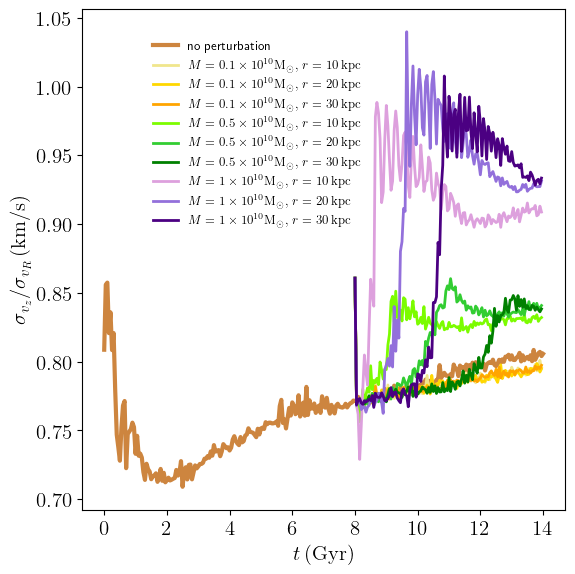

In [25]:
plt.figure(figsize=[6,6])#, dpi=300)
plt.plot(time, sigma_v, color='peru', lw=3, label='no perturbation')

plt.plot(time_01_10, sigma_v_01_10, color='khaki', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20, sigma_v_01_20, color='gold', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30, sigma_v_01_30, color='orange', ls = '-',  lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10, sigma_v_05_10, color='lawngreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20, sigma_v_05_20, color='limegreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30, sigma_v_05_30, color='green', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10, sigma_v_1_10, color='plum', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20, sigma_v_1_20, color='mediumpurple', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30, sigma_v_1_30, color='indigo', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\sigma_{v_z}/\sigma_{v_R} \, \mathrm{(km/s)}$', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.legend(frameon=False, fontsize=9, loc="center right", bbox_to_anchor=(0.6,0.75))
plt.tight_layout()
#plt.savefig('sigma_v_gb.png')

### Evolução da fração de gás

In [27]:
gas_frac_01_10 = np.empty(n_snapshots)
gas_frac_01_20 = np.empty(n_snapshots)
gas_frac_01_30 = np.empty(n_snapshots)

gas_frac_05_10 = np.empty(n_snapshots)
gas_frac_05_20 = np.empty(n_snapshots)
gas_frac_05_30 = np.empty(n_snapshots)

gas_frac_1_10 = np.empty(n_snapshots)
gas_frac_1_20 = np.empty(n_snapshots)
gas_frac_1_30 = np.empty(n_snapshots)

In [28]:
#fração de gás
for p, path in enumerate(paths):
    for j in range (0, n_snapshots):
            
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        f_gas = f['PartType0']
        m_gas = sum(np.array(f_gas['Masses']))

        f_disk = f['PartType2']
        m_disk = sum(np.array(f_disk['Masses']))

        f_bulge = f['PartType3']
        m_bulge = sum(np.array(f_bulge['Masses']))
            
        if j == 0:
            m_star = 0
                
        else:
            f_star = f['PartType4']
            m_star = sum(np.array(f_star['Masses']))

        #calcular fração de gás
        if p == 0:
            gas_frac_01_10[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
            vR   = (  x * vx + y * vy ) / sqrt(x**2+y**2)
        if p == 1:
            gas_frac_01_20[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
            
        if p == 2:
            gas_frac_01_30[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
            
        if p == 3:
            gas_frac_05_10[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
        
        if p == 4:
            gas_frac_05_20[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
            
        if p == 5:
            gas_frac_05_30[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
        
        if p == 6:
            gas_frac_1_10[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
        
        if p == 7:
            gas_frac_1_20[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)
            
        if p == 8:
            gas_frac_1_30[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)

In [29]:
gas_frac = np.empty(n_snapshots_)

In [30]:
for p, path in enumerate(paths1):
    for j in range (0, n_snapshots_):
            
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        f_gas = f['PartType0']
        m_gas = sum(np.array(f_gas['Masses']))

        f_disk = f['PartType2']
        m_disk = sum(np.array(f_disk['Masses']))

        f_bulge = f['PartType3']
        m_bulge = sum(np.array(f_bulge['Masses']))
            
        if j == 0:
            m_star = 0
                
        else:
            f_star = f['PartType4']
            m_star = sum(np.array(f_star['Masses']))

        #ler info tempo
        if p == 0:
            time[j] = round(f['Header'].attrs['Time'], 2)

        #calcular fração de gás
        if p == 0:
            gas_frac[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)

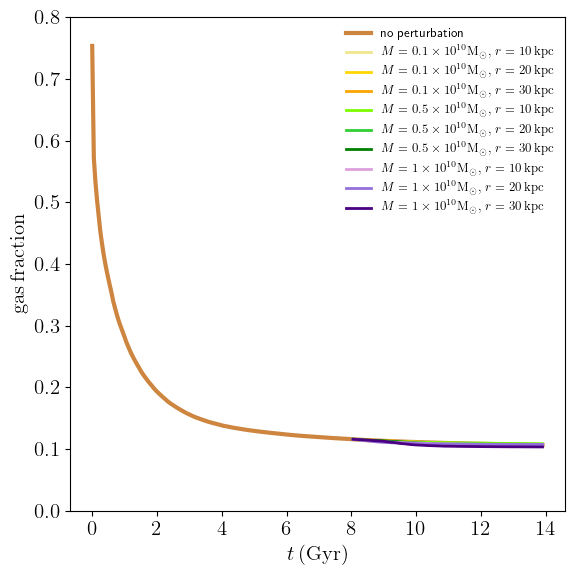

In [37]:
plt.figure(figsize=[6,6])
plt.plot(time[0:279], gas_frac[0:279], color='peru', lw=3, label='no perturbation')

plt.plot(time_01_10[1:119], gas_frac_01_10[1:119], color='khaki', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20[1:119], gas_frac_01_20[1:119], color='gold', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30[1:119], gas_frac_01_30[1:119], color='orange', ls = '-',  lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10[1:119], gas_frac_05_10[1:119], color='lawngreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20[1:119], gas_frac_05_20[1:119], color='limegreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30[1:119], gas_frac_05_30[1:119], color='green', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10[1:119], gas_frac_1_10[1:119], color='plum', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20[1:119], gas_frac_1_20[1:119], color='mediumpurple', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30[1:119], gas_frac_1_30[1:119], color='indigo', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\mathrm{gas \, fraction}$', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.ylim(0, 0.8)
plt.legend(frameon=False, fontsize=9)
plt.tight_layout()
#plt.savefig('gas_frac.png')

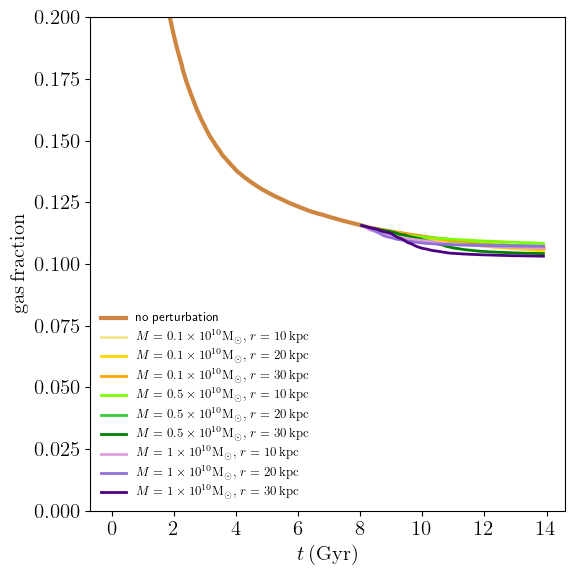

In [40]:
plt.figure(figsize=[6,6])
plt.plot(time[0:279], gas_frac[0:279], color='peru', lw=3, label='no perturbation')

plt.plot(time_01_10[1:119], gas_frac_01_10[1:119], color='khaki', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_01_20[1:119], gas_frac_01_20[1:119], color='gold', ls = '-', lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_01_30[1:119], gas_frac_01_30[1:119], color='orange', ls = '-',  lw = 2,
         label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_05_10[1:119], gas_frac_05_10[1:119], color='lawngreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_05_20[1:119], gas_frac_05_20[1:119], color='limegreen', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_05_30[1:119], gas_frac_05_30[1:119], color='green', ls = '-', lw = 2,
         label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.plot(time_1_10[1:119], gas_frac_1_10[1:119], color='plum', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
plt.plot(time_1_20[1:119], gas_frac_1_20[1:119], color='mediumpurple', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
plt.plot(time_1_30[1:119], gas_frac_1_30[1:119], color='indigo', ls = '-', lw = 2,
         label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\mathrm{gas \, fraction}$', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.ylim(0, 0.2)
plt.legend(frameon=False, loc='lower left', fontsize=9)
plt.tight_layout()
#plt.savefig('gas_frac1.png')

### Taxa de fomação estelar

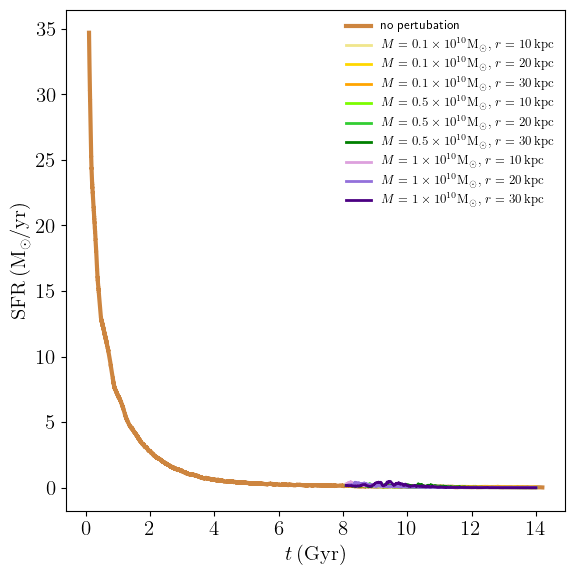

In [39]:
#star formation rate
plt.figure(figsize=[6,6])

for p, path in enumerate(paths1):
    t, sfr = np.loadtxt(path+'sfr.txt', usecols=(0,2), unpack=True)
        
    cond = np.argwhere(t>=0.1).flatten()
    
    plt.plot(t[cond], sfr[cond],  color='peru', lw=3, label='no pertubation')
    
for p, path in enumerate(paths):
    t, sfr = np.loadtxt(path+'sfr.txt', usecols=(0,2), unpack=True)
        
    cond = np.argwhere(t>=0.1).flatten()
    
    if p == 0:
        plt.plot(t[cond]+8.0, sfr[cond], color='khaki', ls = '-', lw = 2, 
                 label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$') 
    if p == 1:
        plt.plot(t[cond]+8.0, sfr[cond], color='gold', ls = '-', lw = 2, 
                 label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
    if p == 2:
        plt.plot(t[cond]+8.0, sfr[cond], color='orange', ls = '-', lw = 2, 
                 label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
    if p == 3:
        plt.plot(t[cond]+8.0, sfr[cond], color='lawngreen', ls = '-', lw = 2,
                 label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
    if p == 4:
        plt.plot(t[cond]+8.0, sfr[cond], color='limegreen', ls = '-', lw = 2,
                 label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
    if p == 5:
        plt.plot(t[cond]+8.0, sfr[cond], color='green', ls = '-', lw = 2,
                 label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
    if p == 6:
        plt.plot(t[cond]+8.0, sfr[cond], color='plum', ls = '-', lw = 2,
                 label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
    if p == 7:
        plt.plot(t[cond]+8.0, sfr[cond], color='mediumpurple', ls = '-', lw = 2,
                 label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
    if p == 8:
        plt.plot(t[cond]+8.0, sfr[cond], color='indigo', ls = '-', lw = 2,
                 label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

    
plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\mathrm{SFR \, ({M}_\odot/yr)}$', fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])  
plt.tight_layout()
#plt.savefig('sfr1.png')

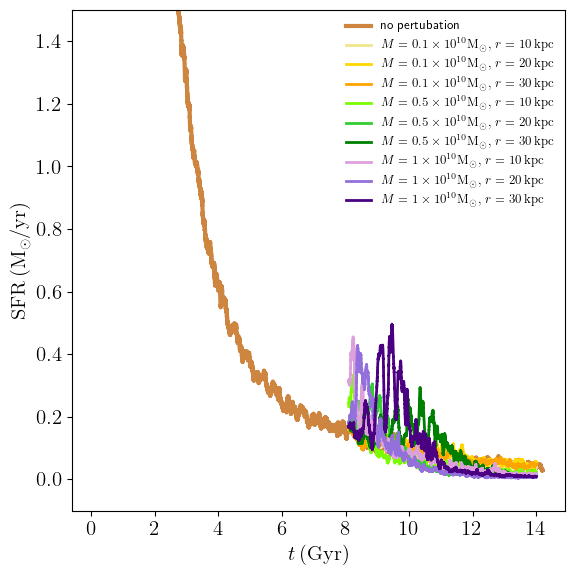

In [41]:
#star formation rate
plt.figure(figsize=[6,6])

for p, path in enumerate(paths1):
    t, sfr = np.loadtxt(path+'sfr.txt', usecols=(0,2), unpack=True)
        
    cond = np.argwhere(t>=0.1).flatten()
    
    plt.plot(t[cond], sfr[cond],  color='peru', lw=3, label='no pertubation')
    
for p, path in enumerate(paths):
    t, sfr = np.loadtxt(path+'sfr.txt', usecols=(0,2), unpack=True)
        
    cond = np.argwhere(t>=0.1).flatten()
    
    if p == 0:
        plt.plot(t[cond]+8.0, sfr[cond], color='khaki', ls = '-', lw = 2, 
                 label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$') 
    if p == 1:
        plt.plot(t[cond]+8.0, sfr[cond], color='gold', ls = '-', lw = 2, 
                 label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
    if p == 2:
        plt.plot(t[cond]+8.0, sfr[cond], color='orange', ls = '-', lw = 2, 
                 label=r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
    if p == 3:
        plt.plot(t[cond]+8.0, sfr[cond], color='lawngreen', ls = '-', lw = 2,
                 label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
    if p == 4:
        plt.plot(t[cond]+8.0, sfr[cond], color='limegreen', ls = '-', lw = 2,
                 label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
    if p == 5:
        plt.plot(t[cond]+8.0, sfr[cond], color='green', ls = '-', lw = 2,
                 label=r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
    if p == 6:
        plt.plot(t[cond]+8.0, sfr[cond], color='plum', ls = '-', lw = 2,
                 label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
    if p == 7:
        plt.plot(t[cond]+8.0, sfr[cond], color='mediumpurple', ls = '-', lw = 2,
                 label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
    if p == 8:
        plt.plot(t[cond]+8.0, sfr[cond], color='indigo', ls = '-', lw = 2,
                 label=r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')

    
plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\mathrm{SFR \, ({M}_\odot/yr)}$', fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])  
plt.ylim(-0.1,1.5)
plt.tight_layout()
#plt.savefig('sfr2.png')

### Órbita do satélite

In [6]:
cm_x_01_10 = np.empty(n_snapshots)
cm_y_01_10 = np.empty(n_snapshots)
cm_z_01_10 = np.empty(n_snapshots)

cm_x_01_20 = np.empty(n_snapshots)
cm_y_01_20 = np.empty(n_snapshots)
cm_z_01_20 = np.empty(n_snapshots)

cm_x_01_30 = np.empty(n_snapshots)
cm_y_01_30 = np.empty(n_snapshots)
cm_z_01_30 = np.empty(n_snapshots)

cm_x_05_10 = np.empty(n_snapshots)
cm_y_05_10 = np.empty(n_snapshots)
cm_z_05_10 = np.empty(n_snapshots)

cm_x_05_20 = np.empty(n_snapshots)
cm_y_05_20 = np.empty(n_snapshots)
cm_z_05_20 = np.empty(n_snapshots)

cm_x_05_30 = np.empty(n_snapshots)
cm_y_05_30 = np.empty(n_snapshots)
cm_z_05_30 = np.empty(n_snapshots)

cm_x_1_10 = np.empty(n_snapshots)
cm_y_1_10 = np.empty(n_snapshots)
cm_z_1_10 = np.empty(n_snapshots)

cm_x_1_20 = np.empty(n_snapshots)
cm_y_1_20 = np.empty(n_snapshots)
cm_z_1_20 = np.empty(n_snapshots)

cm_x_1_30 = np.empty(n_snapshots)
cm_y_1_30 = np.empty(n_snapshots)
cm_z_1_30 = np.empty(n_snapshots)

In [7]:
for p, path in enumerate(paths):
    snapshot = path + 'snapshot_000.hdf5'

    #ler snapshot
    f = h5py.File(snapshot, 'r')

    #ler info disco
    f_disk = f['PartType2']

    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    m_disk = np.array(f_disk['Masses'])
    
    x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        
    for j in range (0, n_snapshots):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        #ler info satélite
        f_bndry = f['PartType5']

        x_bndry = np.array(f_bndry['Coordinates'][:,0])
        y_bndry = np.array(f_bndry['Coordinates'][:,1])
        z_bndry = np.array(f_bndry['Coordinates'][:,2])
        m_bndry = np.array(f_bndry['Masses'])

        if p == 0:
            cm_x_01_10[j], cm_y_01_10[j], cm_z_01_10[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 1:
            cm_x_01_20[j], cm_y_01_20[j], cm_z_01_20[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 2:
            cm_x_01_30[j], cm_y_01_30[j], cm_z_01_30[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 3:
            cm_x_05_10[j], cm_y_05_10[j], cm_z_05_10[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 4:
            cm_x_05_20[j], cm_y_05_20[j], cm_z_05_20[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 5:
            cm_x_05_30[j], cm_y_05_30[j], cm_z_05_30[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 6:
            cm_x_1_10[j], cm_y_1_10[j], cm_z_1_10[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 7:
            cm_x_1_20[j], cm_y_1_20[j], cm_z_1_20[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)
        if p == 8:
            cm_x_1_30[j], cm_y_1_30[j], cm_z_1_30[j] = com(m=m_bndry, x=x_bndry, y=y_bndry,
                                                                z=z_bndry)

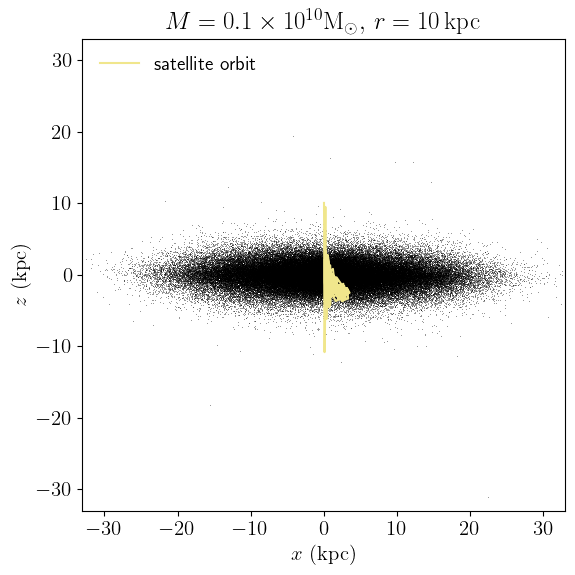

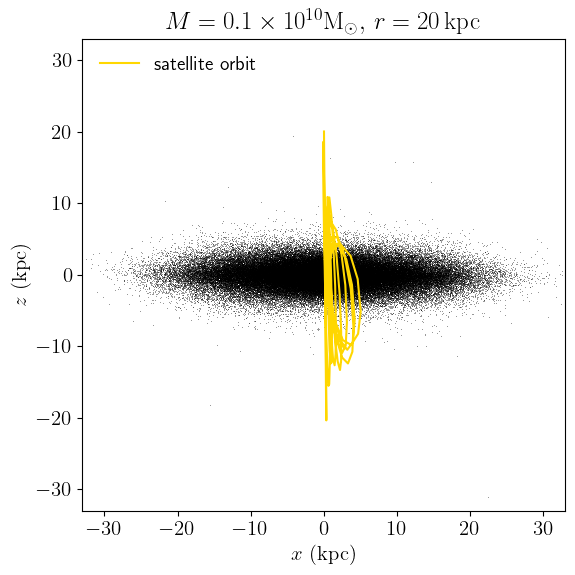

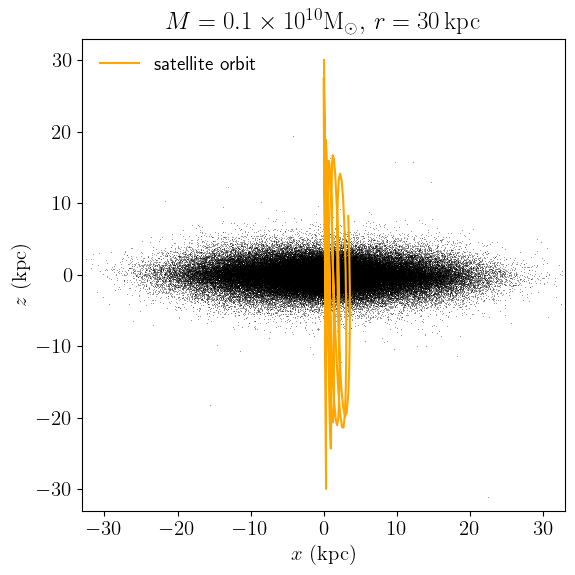

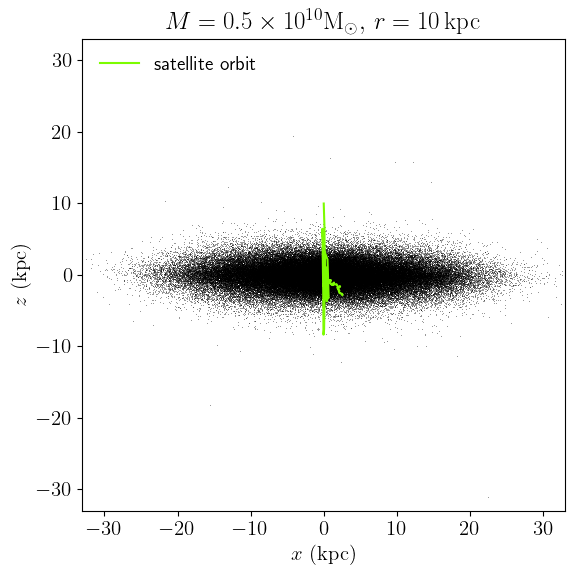

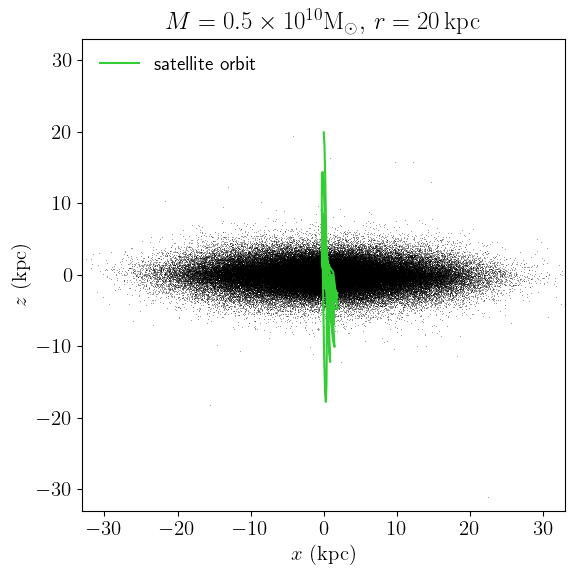

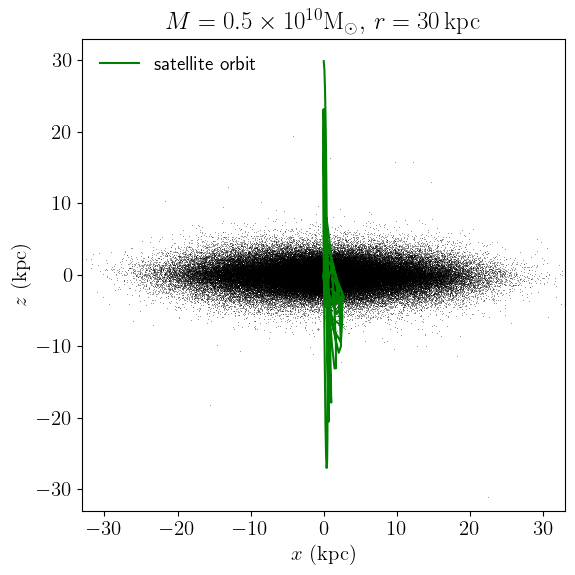

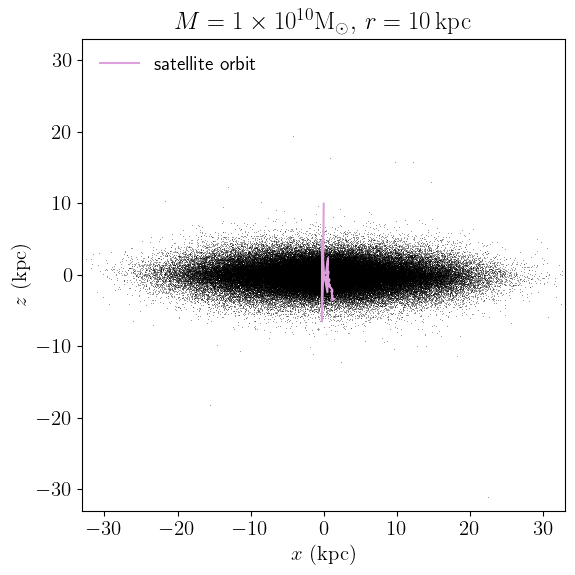

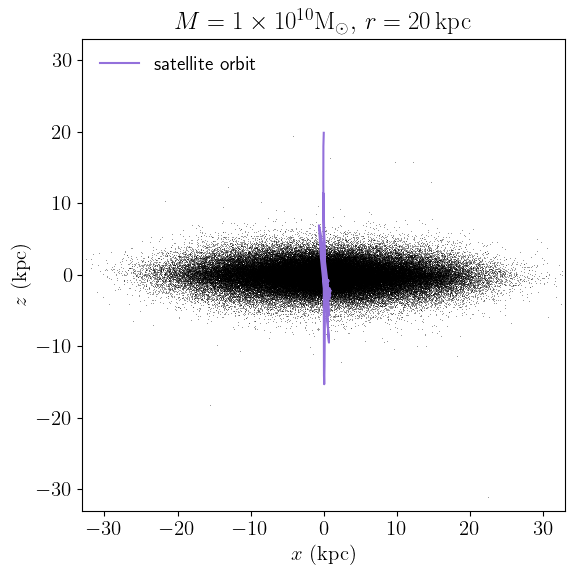

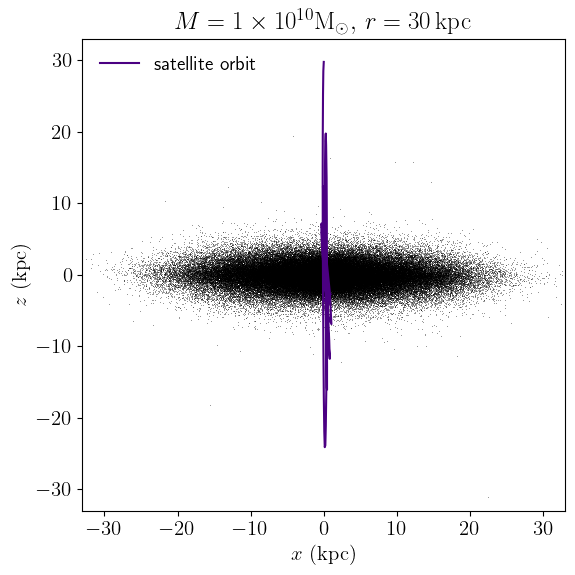

In [8]:
for i in range (0, 9):
    if i == 0:   
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_01_10, cm_z_01_10, color='khaki', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-0.1-10.png')
        
    if i == 1:   
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_01_20, cm_z_01_20, color='gold', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-0.1-20.png')
    
    if i == 2:   
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_01_30, cm_z_01_30, color='orange', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-0.1-30.png')
        
    if i == 3:   
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_05_10, cm_z_05_10, color='lawngreen', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-0.5-10.png')
        
    if i == 4:   
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_05_20, cm_z_05_20, color='limegreen', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-0.5-20.png')
    
    if i == 5:   
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_05_30, cm_z_05_30, color='green', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-0.5-30.png')
    
    if i == 6: 
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_1_10, cm_z_1_10, color='plum', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 10 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-1-10.png')
        
    if i == 7: 
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_1_20, cm_z_1_20, color='mediumpurple', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 20 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-1-20.png')
        
    if i == 8: 
        plt.figure(figsize=[6,6])
        plt.plot(x_disk, z_disk, 'k,', alpha=0.4)
        plt.plot(cm_x_1_30, cm_z_1_30, color='indigo', label='satellite orbit')
        plt.xlabel(r'$x~({\rm kpc})$', fontsize=15)
        plt.ylabel(r'$z~({\rm kpc})$', fontsize=15)
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        plt.ylim(-33, 33)
        plt.xlim(-33, 33)
        plt.title(r'$ M = 1 \times 10^{10}\mathrm{{M}_\odot}, \,r = 30 \, \mathrm{kpc}$')
        plt.tight_layout()
        #plt.savefig('orbita-nb-1-30.png')

### Mapas de altura e velocidade vertical

In [7]:
#figuras para o texto
plt.rcParams['figure.figsize'  ] = (3.5,1.4)
plt.rcParams['font.size'       ] = 7
plt.rcParams['legend.fontsize' ] = 7
plt.rcParams['legend.frameon'  ] = False
plt.rcParams['font.family'     ] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction' ] = 'in'
plt.rcParams['ytick.direction' ] = 'in'
plt.rcParams['xtick.top'       ] = True
plt.rcParams['ytick.right'     ] = True
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['xtick.major.width'] = 0.75
plt.rcParams['xtick.minor.width'] = 0
plt.rcParams['ytick.major.width'] = 0.75
plt.rcParams['ytick.minor.width'] = 0

In [9]:
snapshots=[160,220,280] #galaxia barrada
#snapshots=[0,60,120] #galaxia barrada + satelite

Qlist = []
Qlist1 = []
    
for s, snap in enumerate(snapshots): 
    index = str(snap).zfill(3)
    snapshot = 'n_barrada/' + f'snapshot_{index}.hdf5' 
    #substituir o path, por enquanto só dá um de cada vez

    #ler snapshot
    f = h5py.File(snapshot, 'r')

    #ler info disk e stars
    f_disk = f['PartType2']

    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    vx_disk = np.array(f_disk['Velocities'][:,0])
    vy_disk = np.array(f_disk['Velocities'][:,1])
    vz_disk = np.array(f_disk['Velocities'][:,2])
    m_disk = np.array(f_disk['Masses'])
    Ndisk = len(np.array(f_disk['ParticleIDs']))

    f_star = f['PartType4']

    x_star = np.array(f_star['Coordinates'][:,0])
    y_star = np.array(f_star['Coordinates'][:,1])
    z_star = np.array(f_star['Coordinates'][:,2])
    vx_star = np.array(f_star['Velocities'][:,0])
    vy_star = np.array(f_star['Velocities'][:,1])
    vz_star = np.array(f_star['Velocities'][:,2])
    m_star = np.array(f_star['Masses'])
    Nstar = len(np.array(f_star['ParticleIDs']))
        
    #corrigir posição - centro de massa - disk
    x_new_disk, y_new_disk, z_new_disk = shift_com(m_disk, x_disk, y_disk, z_disk)
    vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

    #corrigir posição - momento angular - disk
    theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
    x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
    x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)

    #corrigir theta bar - disk
    thetas = theta_bar(m=m_disk, x=x, y=y, Rmax=5.0)
    x_new_disk2, y_new_disk2 = corr_theta_b(N=Ndisk, x=x, y=y, theta=thetas)
    
    #corrigir posição - centro de massa - stars
    x_new_star, y_new_star, z_new_star = shift_com(m_star, x_star, y_star, z_star)
    vx_new_star, vy_new_star, vz_new_star = shift_com(m_star, vx_star, vy_star, vz_star)

    #corrigir posição - momento angular - stars
    theta_s, phi_s = theta_phi(N=Nstar, x=x_new_star, y=y_new_star, z=z_new_star, vx=vx_new_star,
                               vy=vy_new_star, vz=vz_new_star, m=m_star)

    x_s, y_s, vx_s, vy_s = angular_momentum_1(N=Nstar, x=x_new_star, y=y_new_star, vx=vx_new_star,
                                          vy=vy_new_star, theta=theta_s)

    x_s, z_s, vx_s, vz_s = angular_momentum_2(N=Nstar, x=x_s, z=z_new_star, vx=vx_s, vz=vz_new_star,
                                                  phi=phi_s)

    #corrigir theta bar - disk
    thetas = theta_bar(m=m_star, x=x_s, y=y_s, Rmax=5.0)
    x_new_star2, y_new_star2 = corr_theta_b(N=Nstar, x=x_s, y=y_s, theta=thetas)
    
    #juntar componentes
    x_tot = np.concatenate((x_new_disk2, x_new_star2))
    y_tot = np.concatenate((y_new_disk2, y_new_star2))
    z_tot = np.concatenate((z, z_s))
    vx_tot = np.concatenate((vx, vx_s))
    vy_tot = np.concatenate((vy, vy_s))
    vz_tot = np.concatenate((vz, vz_s))
    m_tot = np.concatenate((m_disk, m_star))
    
    #mapas de posição e velocidade
    Nbins = 80

    Rmax =  32.0 #kpc
    xmin = ymin = -Rmax
    xmax = ymax = Rmax

    results, xb, yb, binnum = stats.binned_statistic_2d(x_tot, y_tot, z_tot, 
                                    statistic='mean', bins=Nbins, range=[[xmin,xmax],[ymin,ymax]])

    results1, xb, yb, binnum = stats.binned_statistic_2d(x_tot, y_tot, vz_tot, 
                                    statistic='mean', bins=Nbins, range=[[xmin,xmax],[ymin,ymax]])
    #mudar para statistic='std' para desvio de posição e velocidades

    extent = [xb[0], xb[-1], yb[0], yb[-1]]

    Q = results
    Qlist.append(Q)
    Q1 = results1
    Qlist1.append(Q1)

/tmp/ipykernel_22256/3472315815.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_22256/3472315815.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


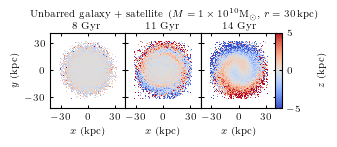

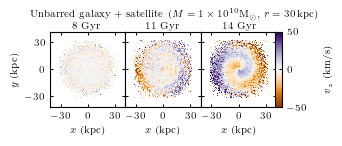

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

# ax1.set_title("8 Gyr", fontsize=6.5)
# ax2.set_title("12 Gyr", fontsize=6.5)
# ax3.set_title("14 Gyr", fontsize=6.5)

ax1.set_title(" ", fontsize=6.5)
ax2.set_title(" ", fontsize=6.5)
ax3.set_title(" ", fontsize=6.5)

im1 = ax1.imshow(Qlist[0].T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest',
                 vmin=-5.0, vmax=5.0)
im2 = ax2.imshow(Qlist[1].T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest', 
                 vmin=-5.0, vmax=5.0)
im3 = ax3.imshow(Qlist[2].T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest', 
                 vmin=-5.0, vmax=5.0)

for ax in fig.get_axes():
    ax.set_xlabel(r'$x$ (kpc)')  
    ax.set_ylabel(r'$y$ (kpc)')
    ax.set_xlim(-42,42)
    ax.set_xticks(np.arange(-30,31,30))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim(-42,42)
    ax.set_yticks(np.arange(-30,31,30))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.label_outer()
ax3.set_xticks(np.arange(-30,31,30))
ax1.set_yticks(np.arange(-30,31,30))

fig.subplots_adjust(right=0.9)

#cax1 = fig.add_axes([0.85, 0.27, 0.025, 0.54])
cax1 = fig.add_axes([0.82, 0.28, 0.020, 0.54])
cb1  = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$z$ (kpc)', labelpad=12)

fig.subplots_adjust(left=0.47, bottom=0.5, top=1.8, right=3.0, hspace=0.0, wspace=0.0)
plt.tight_layout()
# text = 'Barred galaxy + satellite ' + r'($M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$)'
# plt.text(-145, 2.7, text, fontsize=7)
# #plt.text(-85, 2.7, text, fontsize=7)
# text1 = '8 Gyr'
# plt.text(-116, 2.2, text1, fontsize=7)
# text2 = '11 Gyr'
# plt.text(-75, 2.2, text2, fontsize=7)
# text3 = '14 Gyr'
# plt.text(-32, 2.2, text3, fontsize=7)

text = 'Unbarred galaxy + satellite ' + r'($M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$)'
plt.text(-35, 6.9, text, fontsize=7)
text1 = '8 Gyr'
plt.text(-29, 5.5, text1, fontsize=7)
text2 = '11 Gyr'
plt.text(-18.5, 5.5, text2, fontsize=7)
text3 = '14 Gyr'
plt.text(-7.5, 5.5, text3, fontsize=7)

plt.savefig('mapz-nb-1-30.png', dpi=200)


#_____________________________#

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

# ax1.set_title("8 Gyr")
# ax2.set_title("12 Gyr")
# ax3.set_title("14 Gyr")

ax1.set_title(" ", fontsize=6.5)
ax2.set_title(" ", fontsize=6.5)
ax3.set_title(" ", fontsize=6.5)

im1 = ax1.imshow(Qlist1[0].T, extent=extent, origin='lower', cmap="PuOr", interpolation='nearest',
                 vmin=-50.0, vmax=50.0)
im2 = ax2.imshow(Qlist1[1].T, extent=extent, origin='lower', cmap="PuOr", interpolation='nearest', 
                 vmin=-50.0, vmax=50.0)
im3 = ax3.imshow(Qlist1[2].T, extent=extent, origin='lower', cmap="PuOr", interpolation='nearest', 
                 vmin=-50.0, vmax=50.0)


for ax in fig.get_axes():
    ax.set_xlabel(r'$x$ (kpc)')  
    ax.set_ylabel(r'$y$ (kpc)')
    ax.set_xlim(-42,42)
    ax.set_xticks(np.arange(-30,31,30))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim(-42,42)
    ax.set_yticks(np.arange(-30,31,30))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.label_outer()
ax3.set_xticks(np.arange(-30,31,30))
ax1.set_yticks(np.arange(-30,31,30))

fig.subplots_adjust(right=0.9)

cax1 = fig.add_axes([0.82, 0.28, 0.020, 0.54])
cb1  = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$v_z$ (km/s)', labelpad=12)

fig.subplots_adjust(left=0.47, bottom=0.5, top=1.8, right=3.0, hspace=0.0, wspace=0.0)
plt.tight_layout()

text = 'Unbarred galaxy + satellite ' + r'($M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$)'
plt.text(-35, 67.8, text, fontsize=7)
text1 = '8 Gyr'
plt.text(-29, 54.5, text1, fontsize=7)
text2 = '11 Gyr'
plt.text(-18.5, 54.5, text2, fontsize=7)
text3 = '14 Gyr'
plt.text(-7.5, 54.5, text3, fontsize=7)

plt.savefig('mapvz-nb-1-30.png', dpi=200)

/tmp/ipykernel_19322/65550396.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_19322/65550396.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


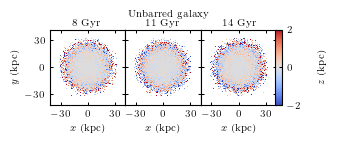

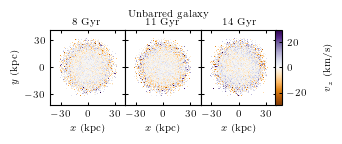

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

# ax1.set_title("8 Gyr", fontsize=6.5)
# ax2.set_title("12 Gyr", fontsize=6.5)
# ax3.set_title("14 Gyr", fontsize=6.5)

ax1.set_title(" ", fontsize=6.5)
ax2.set_title(" ", fontsize=6.5)
ax3.set_title(" ", fontsize=6.5)

im1 = ax1.imshow(Qlist[0].T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest',
                 vmin=-2.0, vmax=2.0)
im2 = ax2.imshow(Qlist[1].T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest', 
                 vmin=-2.0, vmax=2.0)
im3 = ax3.imshow(Qlist[2].T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest', 
                 vmin=-2.0, vmax=2.0)

for ax in fig.get_axes():
    ax.set_xlabel(r'$x$ (kpc)')  
    ax.set_ylabel(r'$y$ (kpc)')
    ax.set_xlim(-42,42)
    ax.set_xticks(np.arange(-30,31,30))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim(-42,42)
    ax.set_yticks(np.arange(-30,31,30))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.label_outer()
ax3.set_xticks(np.arange(-30,31,30))
ax1.set_yticks(np.arange(-30,31,30))

fig.subplots_adjust(right=0.9)

#cax1 = fig.add_axes([0.85, 0.27, 0.025, 0.54])
cax1 = fig.add_axes([0.82, 0.28, 0.020, 0.54])
cb1  = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$z$ (kpc)', labelpad=12)

fig.subplots_adjust(left=0.47, bottom=0.5, top=1.8, right=3.0, hspace=0.0, wspace=0.0)
plt.tight_layout()
# text = 'Barred galaxy + satellite ' + r'($M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$)'
# plt.text(-145, 2.7, text, fontsize=7)
# #plt.text(-85, 2.7, text, fontsize=7)
# text1 = '8 Gyr'
# plt.text(-116, 2.2, text1, fontsize=7)
# text2 = '11 Gyr'
# plt.text(-75, 2.2, text2, fontsize=7)
# text3 = '14 Gyr'
# plt.text(-32, 2.2, text3, fontsize=7)

text = 'Unbarred galaxy'# + satellite ' + r'($M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$)'
plt.text(-21, 2.7, text, fontsize=7)
text1 = '8 Gyr'
plt.text(-29, 2.2, text1, fontsize=7)
text2 = '11 Gyr'
plt.text(-18.5, 2.2, text2, fontsize=7)
text3 = '14 Gyr'
plt.text(-7.5, 2.2, text3, fontsize=7)

plt.savefig('mapz-nb.png', dpi=200)


#_____________________________#

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

# ax1.set_title("8 Gyr")
# ax2.set_title("12 Gyr")
# ax3.set_title("14 Gyr")

ax1.set_title(" ", fontsize=6.5)
ax2.set_title(" ", fontsize=6.5)
ax3.set_title(" ", fontsize=6.5)

im1 = ax1.imshow(Qlist1[0].T, extent=extent, origin='lower', cmap="PuOr", interpolation='nearest',
                 vmin=-30.0, vmax=30.0)
im2 = ax2.imshow(Qlist1[1].T, extent=extent, origin='lower', cmap="PuOr", interpolation='nearest', 
                 vmin=-30.0, vmax=30.0)
im3 = ax3.imshow(Qlist1[2].T, extent=extent, origin='lower', cmap="PuOr", interpolation='nearest', 
                 vmin=-30.0, vmax=30.0)


for ax in fig.get_axes():
    ax.set_xlabel(r'$x$ (kpc)')  
    ax.set_ylabel(r'$y$ (kpc)')
    ax.set_xlim(-42,42)
    ax.set_xticks(np.arange(-30,31,30))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim(-42,42)
    ax.set_yticks(np.arange(-30,31,30))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.label_outer()
ax3.set_xticks(np.arange(-30,31,30))
ax1.set_yticks(np.arange(-30,31,30))

fig.subplots_adjust(right=0.9)

cax1 = fig.add_axes([0.82, 0.28, 0.020, 0.54])
cb1  = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$v_z$ (km/s)', labelpad=12)

fig.subplots_adjust(left=0.47, bottom=0.5, top=1.8, right=3.0, hspace=0.0, wspace=0.0)
plt.tight_layout()

text = 'Unbarred galaxy'# + satellite ' + r'($M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$)'
plt.text(-21, 40.5, text, fontsize=7) #35
text1 = '8 Gyr'
plt.text(-29, 34, text1, fontsize=7)
text2 = '11 Gyr'
plt.text(-18.5, 34, text2, fontsize=7)
text3 = '14 Gyr'
plt.text(-7.5, 34, text3, fontsize=7)

plt.savefig('mapvz-nb.png', dpi=200)